In [1]:
#import pertinent libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/Users/danherman/Desktop/oud_treatment_outcome/data/clean_data/data.csv')
test_data = pd.read_csv('/Users/danherman/Desktop/oud_treatment_outcome/data/clean_data/testing_data.csv')

In [3]:
data.shape, test_data.shape

((1045, 234), (262, 234))

In [4]:
data.outcome.value_counts(),test_data.outcome.value_counts()

(outcome
 0.0    734
 1.0    311
 Name: count, dtype: int64,
 outcome
 0.0    172
 1.0     90
 Name: count, dtype: int64)

In [5]:
# setup the testing data
X_test, y_test = test_data.drop('outcome', axis=1), test_data.outcome

In [6]:
X_test.shape, y_test.shape

((262, 233), (262,))

In [7]:
# preprocess the target variable separately

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

target =le.fit_transform(data.outcome)
y_test = le.transform(test_data.outcome)

In [8]:
from sklearn.model_selection import train_test_split

# set the x and y variables
X = data.drop(columns=['outcome'], axis=1)
y = target

# split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

In [9]:
pd.Series(y_train).value_counts(), pd.Series(y_val).value_counts()

(0    590
 1    246
 Name: count, dtype: int64,
 0    144
 1     65
 Name: count, dtype: int64)

### Fit the model

In [10]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit 
from xgboost import XGBClassifier

In [11]:
parameters = [
    {'n_estimators':[150,200,300], 'learning_rate':[0.1,0.01,0.001]}
]

grid_search = GridSearchCV(XGBClassifier(), 
                                        parameters,
                                        verbose=True, 
                                        scoring='f1', 
                                        cv=StratifiedShuffleSplit(n_splits=5),
                                        n_jobs=8)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=None,
            train_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=8,
             param_grid=[{'learning_rate': [0.1, 0.01, 0.001],
                          'n_estimators': [150, 200, 300]}],
             scoring='f1', verbose=True)

In [12]:
print("Best score: %0.3f" % grid_search.best_score_)


Best score: 0.708


In [13]:
best_parameters = grid_search.best_estimator_.get_params()

best_parameters

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.01,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 300,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [14]:
#print the accuracy for each parameter combination\n",
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.688 (+/-0.114) for {'learning_rate': 0.1, 'n_estimators': 150}
0.681 (+/-0.118) for {'learning_rate': 0.1, 'n_estimators': 200}
0.674 (+/-0.135) for {'learning_rate': 0.1, 'n_estimators': 300}
0.675 (+/-0.150) for {'learning_rate': 0.01, 'n_estimators': 150}
0.673 (+/-0.151) for {'learning_rate': 0.01, 'n_estimators': 200}
0.708 (+/-0.118) for {'learning_rate': 0.01, 'n_estimators': 300}
0.000 (+/-0.000) for {'learning_rate': 0.001, 'n_estimators': 150}
0.000 (+/-0.000) for {'learning_rate': 0.001, 'n_estimators': 200}
0.000 (+/-0.000) for {'learning_rate': 0.001, 'n_estimators': 300}


In [15]:
#refit model with all data
clf = XGBClassifier(n_estimators=300,
                    max_depth=3,
                     learning_rate=0.1,
                     n_jobs=8,
                   importance_type='coverage')

clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric=["auc","error"], verbose=False)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type='coverage',
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=8,
              num_parallel_tree=None, random_state=None, ...)

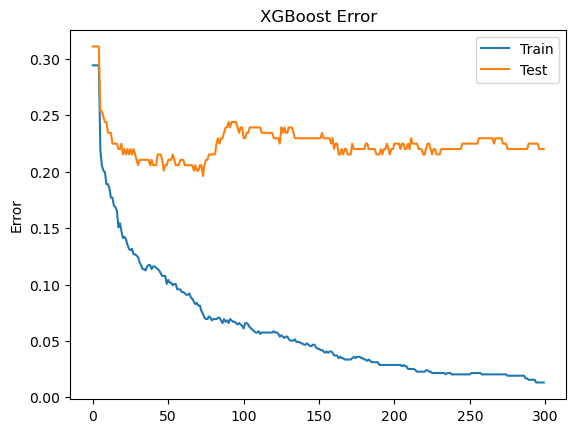

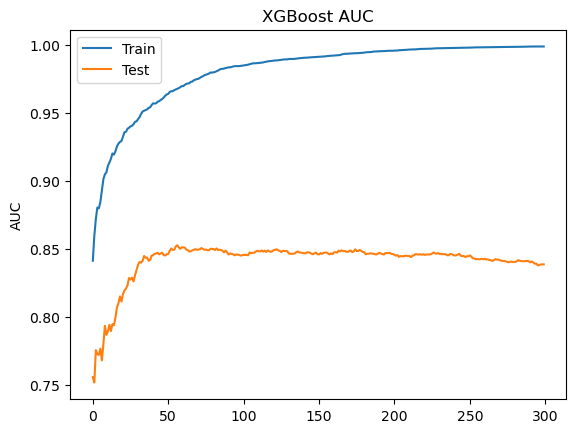

In [16]:
# retrieve performance metrics
results = clf.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Error')
plt.title('XGBoost Error')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

### Evaluate the fitted model

In [17]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, roc_auc_score, roc_curve
from itertools import cycle
from scipy import interp

In [18]:
y_pred_train = clf.predict(X_train)
y_pred_val = clf.predict(X_val)
y_pred_test = grid_search.predict(X_test)

y_train_prob = clf.predict_proba(X_train)
y_val_prob = clf.predict_proba(X_val)
y_test_prob = clf.predict_proba(X_test)

In [19]:
print(classification_report(y_val,y_pred_val))

              precision    recall  f1-score   support

           0       0.81      0.88      0.85       144
           1       0.68      0.55      0.61        65

    accuracy                           0.78       209
   macro avg       0.75      0.72      0.73       209
weighted avg       0.77      0.78      0.77       209



In [20]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       172
           1       0.75      0.59      0.66        90

    accuracy                           0.79       262
   macro avg       0.78      0.74      0.75       262
weighted avg       0.79      0.79      0.78       262



In [21]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       590
           1       0.99      0.96      0.98       246

    accuracy                           0.99       836
   macro avg       0.99      0.98      0.98       836
weighted avg       0.99      0.99      0.99       836



In [22]:
# where do I insert %0.3f 
print('Train Accuracy: %0.3f' % accuracy_score(y_train,y_pred_train))
print('Validation Accuracy: %0.3f' % accuracy_score(y_val,y_pred_val))
print('Test Accuracy: %0.3f' % accuracy_score(y_test,y_pred_test))

Train Accuracy: 0.987
Validation Accuracy: 0.780
Test Accuracy: 0.790


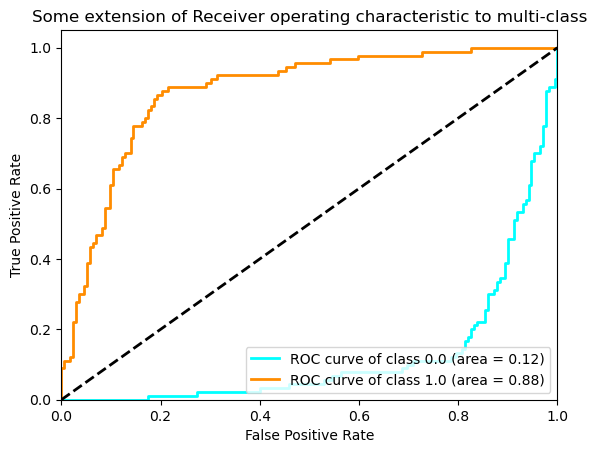

In [23]:
# Plot all ROC curves

from sklearn.preprocessing import label_binarize
#Calculate ROC curve and ROC each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y_bin = label_binarize(y_test, classes=[0,1])
n_classes =2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_test_prob[:,i])
    roc_auc[i] = roc_auc_score(y_test, y_test_prob[:,i])
plt.figure()
lw=2
colors = cycle(['aqua', 'darkorange']) #, 'cornflowerblue' ]) #'deeppink','navy'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(le.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [24]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[154  18]
 [ 37  53]]


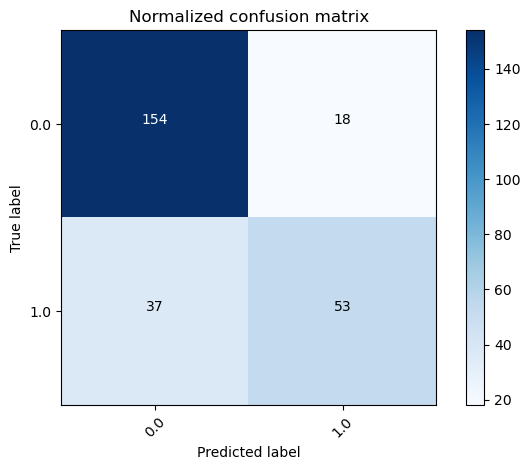

In [25]:
class_names = le.classes_

conf=confusion_matrix(y_test,y_pred_test)
plt.figure()
plot_confusion_matrix(conf, classes=class_names, normalize=False,
                      title='Normalized confusion matrix')
# plt.savefig("cm1.jpg", dpi=900)
plt.show()

In [26]:
import shap

# load JS visualization code to notebook
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

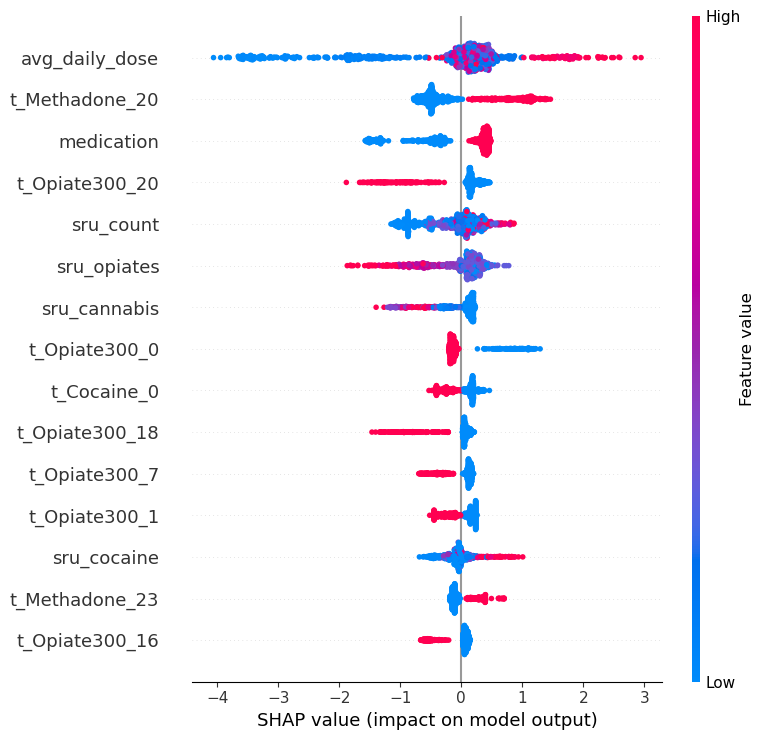

In [27]:
# # shap.force_plot(explainer.expected_value, shap_values, X_smt)
shap.summary_plot(shap_values, X_train, feature_names = X_train.columns,  max_display=15, plot_type="dot")

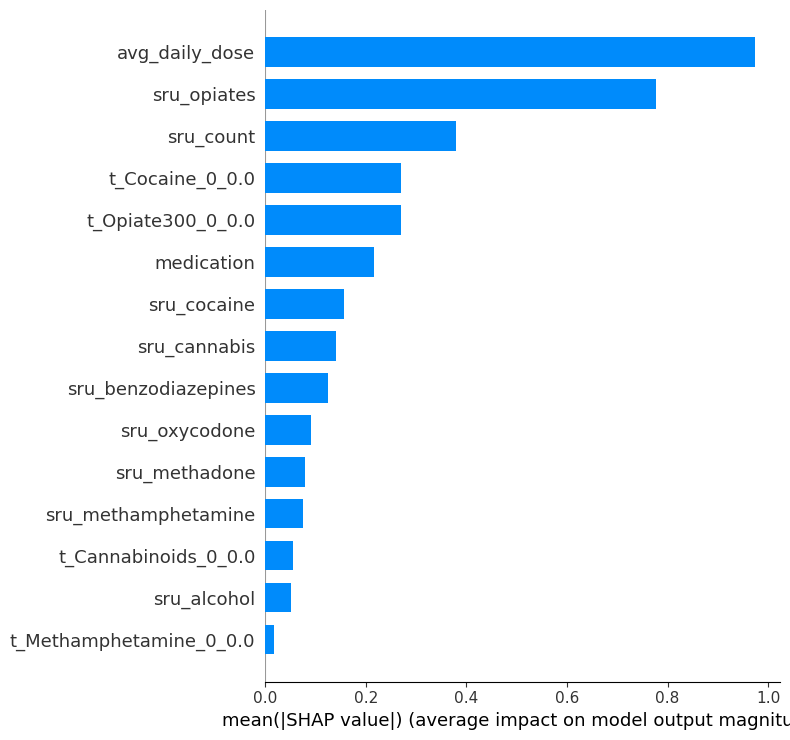

In [85]:
# create shap beeswarm plot
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=15)

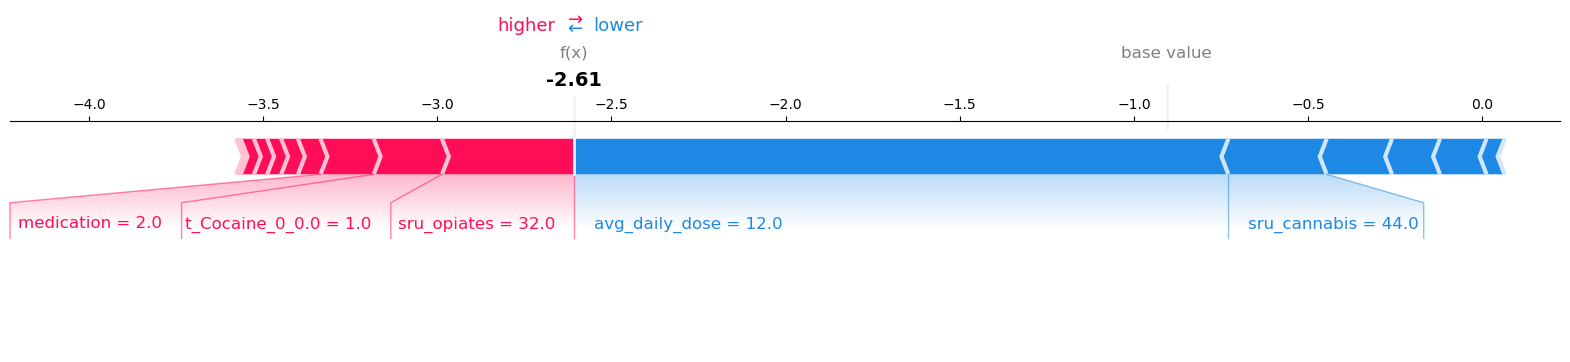

In [86]:
# create shap force plot
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:],matplotlib=True, show=False,)
